In [1]:
!pip install sacrebleu

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu
import json
import csv
from collections import Counter

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the Icelandic_cleaned.json dataset
with open('/content/Icelandic_cleaned.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the first 1,000 English and Icelandic sentences for BLEU and CHRF calculation
en_sentences = [entry['input'] for entry in data[:1000]]
ic_sentences = [entry['output'] for entry in data[:1000]]

# Tokenizer and Vectorization
tokenizer = lambda x: x.split()

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer(sentence))
    return counter

en_vocab = build_vocab(en_sentences)
ic_vocab = build_vocab(ic_sentences)

# Adding special tokens
en_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **en_vocab}
ic_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **ic_vocab}

def sentence_to_tensor(sentence, vocab, max_len=MAX_LEN):
    tokens = tokenizer(sentence)
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
    indices = [vocab['<s>']] + indices + [vocab['</s>']]
    if len(indices) < max_len:
        indices += [vocab['<pad>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return torch.tensor(indices)


VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
BATCH_SIZE = 32
NUM_EPOCHS = 10
MAX_LEN = 50

# Prepare dataset and dataloaders
en_tensor_sentences = [sentence_to_tensor(s, en_vocab) for s in en_sentences]
ic_tensor_sentences = [sentence_to_tensor(s, ic_vocab) for s in ic_sentences]

# Split data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(en_tensor_sentences))
train_en, val_en = en_tensor_sentences[:train_size], en_tensor_sentences[train_size:]
train_ic, val_ic = ic_tensor_sentences[:train_size], ic_tensor_sentences[train_size:]

# Sample Data Printing in Specified Format
def print_sample_data(en_sentences, ic_sentences):
    for i in range(5):
        en_sample = en_sentences[i]
        ic_sample = ic_sentences[i]

        print("EN to IC")
        print("<s>")
        print(f"<en> {en_sample} </en>")
        print(f"<ic> {ic_sample} </ic>")
        print("</s>")

        print("IC to EN")
        print("<s>")
        print(f"<ic> {ic_sample} </ic>")
        print(f"<en> {en_sample} </en>")
        print("</s>")
        print()

print_sample_data(en_sentences, ic_sentences)

EN to IC
<s>
<en> give three tips for staying healthy </en>
<ic> gefðu þrjú ráð til að halda heilsu </ic>
</s>
IC to EN
<s>
<ic> gefðu þrjú ráð til að halda heilsu </ic>
<en> give three tips for staying healthy </en>
</s>

EN to IC
<s>
<en> 1 eat a balanced and nutritious diet make sure your meals are inclusive of a variety of fruits and vegetables lean protein whole grains and healthy fats this helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases 2 engage in regular physical activity exercise is crucial for maintaining strong bones muscles and cardiovascular health aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week 3 get enough sleep getting enough quality sleep is crucial for physical and mental wellbeing it helps to regulate mood improve cognitive function and supports healthy growth and immune function aim for 79 hours of sleep each night </en>
<ic> 1 borðaðu hollt o

In [3]:
# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, en_sentences, ic_sentences):
        self.en_sentences = en_sentences
        self.ic_sentences = ic_sentences

    def __len__(self):
        return len(self.en_sentences)

    def __getitem__(self, idx):
        return self.en_sentences[idx], self.ic_sentences[idx]

# Prepare dataloader
train_dataset = TranslationDataset(train_en, train_ic)
val_dataset = TranslationDataset(val_en, val_ic)

# Define a collate_fn to pad sequences dynamically
def collate_fn(batch):
    en_batch, ic_batch = zip(*batch)
    en_batch = torch.stack(en_batch, dim=0)
    ic_batch = torch.stack(ic_batch, dim=0)
    return en_batch, ic_batch

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [4]:

# Seq2Seq Model
class Seq2SeqModel(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim, num_layers=1):
        super(Seq2SeqModel, self).__init__()

        self.encoder_embedding = nn.Embedding(input_dim, embedding_dim)
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.decoder_embedding = nn.Embedding(output_dim, embedding_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, trg):
        embedded_src = self.encoder_embedding(src)
        encoder_output, (hidden, cell) = self.encoder_lstm(embedded_src)

        embedded_trg = self.decoder_embedding(trg)
        decoder_output, _ = self.decoder_lstm(embedded_trg, (hidden, cell))

        output = self.fc_out(decoder_output)
        return output

# Initialize the Seq2Seq model
model = Seq2SeqModel(len(en_vocab), len(ic_vocab), EMBEDDING_DIM, HIDDEN_DIM, num_layers=1).to(DEVICE)

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=ic_vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=10):
    model.to(DEVICE)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for en_batch, ic_batch in train_dataloader:
            en_batch, ic_batch = en_batch.to(DEVICE), ic_batch.to(DEVICE)
            ic_batch = ic_batch.long()

            optimizer.zero_grad()
            output = model(en_batch, ic_batch)

            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            ic_batch = ic_batch.reshape(-1)
            loss = criterion(output, ic_batch)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for en_batch, ic_batch in val_dataloader:
                en_batch, ic_batch = en_batch.to(DEVICE), ic_batch.to(DEVICE)
                ic_batch = ic_batch.long()

                output = model(en_batch, ic_batch)
                output_dim = output.shape[-1]
                output = output.reshape(-1, output_dim)
                ic_batch = ic_batch.reshape(-1)

                loss = criterion(output, ic_batch)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss / len(val_dataloader))

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=NUM_EPOCHS)

# Save the trained model
torch.save(model.state_dict(), 'seq2seq_translation_model.pth')


def translate_new_sentence(model, sentence, src_vocab, tgt_vocab, max_len=MAX_LEN):
    # Prepare input tensor for the source sentence (English)
    model.eval()  # Set model to evaluation mode
    en_indices = [src_vocab.get(word, src_vocab['<unk>']) for word in sentence.split()]  # Handle unknown words
    en_tensor = torch.tensor(en_indices).unsqueeze(0).to(DEVICE)

    # Initialize target sentence for translation (Croatian) with start token
    tgt_tensor = torch.tensor([tgt_vocab['<s>']]).unsqueeze(0).to(DEVICE)

    translated_sentence = []

    for _ in range(max_len):
        with torch.no_grad():
            output = model(en_tensor, tgt_tensor)

        # Get the last output token's prediction (the next word)
        output_token = output.argmax(dim=-1)[:, -1]

        # Get the predicted word from the target vocabulary
        output_token_item = output_token.item()

        # Check if the token is within the target vocabulary range
        if output_token_item not in tgt_vocab.values():
            translated_word = '<unk>'  # Map to <unk> if not found
        else:
            translated_word = list(tgt_vocab.keys())[list(tgt_vocab.values()).index(output_token_item)]

        # Append predicted word to the translated sentence
        translated_sentence.append(translated_word)

        # If we encounter an end token, stop the translation
        if translated_word == '</s>':
            break

        # Update tgt_tensor for next prediction
        tgt_tensor = torch.cat((tgt_tensor, output_token.unsqueeze(0)), dim=-1)

    return ' '.join(translated_sentence)

# BLEU and CHRF Scores Calculation
def calculate_bleu_chrf(en_sentences, ic_sentences, model, en_vocab, ic_vocab, max_len=MAX_LEN):
    bleu_scores = []
    chrf_scores = []

    for en_sentence, ic_sentence in zip(en_sentences, ic_sentences):
        translated_sentence = translate_new_sentence(model, en_sentence, en_vocab, ic_vocab, max_len)

        bleu_score = sacrebleu.corpus_bleu([translated_sentence], [[ic_sentence]]).score
        bleu_scores.append(bleu_score)

        chrf_score = sacrebleu.corpus_chrf([translated_sentence], [[ic_sentence]]).score
        chrf_scores.append(chrf_score)

    return bleu_scores, chrf_scores

lstm_bleu_scores, lstm_chrf_scores = calculate_bleu_chrf(en_sentences, ic_sentences, model, en_vocab, ic_vocab)

# Save BLEU and CHRF scores to CSV
with open('Seq2Seq_BLEU_CHRF_scores.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["BLEU Score", "CHRF Score"])
    for bleu, chrf in zip(lstm_bleu_scores, lstm_chrf_scores):
        writer.writerow([bleu, chrf])






Epoch 1/10, Training Loss: 4.162079634666443, Validation Loss: 1.783459918839591
Epoch 2/10, Training Loss: 1.0344110178947448, Validation Loss: 0.4918278966631208
Epoch 3/10, Training Loss: 0.2632215261459351, Validation Loss: 0.12271245462553841
Epoch 4/10, Training Loss: 0.07123038023710251, Validation Loss: 0.04314851335116795
Epoch 5/10, Training Loss: 0.030836958587169647, Validation Loss: 0.02404651258672987
Epoch 6/10, Training Loss: 0.01885295122861862, Validation Loss: 0.01633326443178313
Epoch 7/10, Training Loss: 0.013474887125194073, Validation Loss: 0.012323189526796341
Epoch 8/10, Training Loss: 0.010358258336782455, Validation Loss: 0.009776035456785135
Epoch 9/10, Training Loss: 0.00829771364107728, Validation Loss: 0.008006346212433917
Epoch 10/10, Training Loss: 0.006895635910332203, Validation Loss: 0.006732985709926912


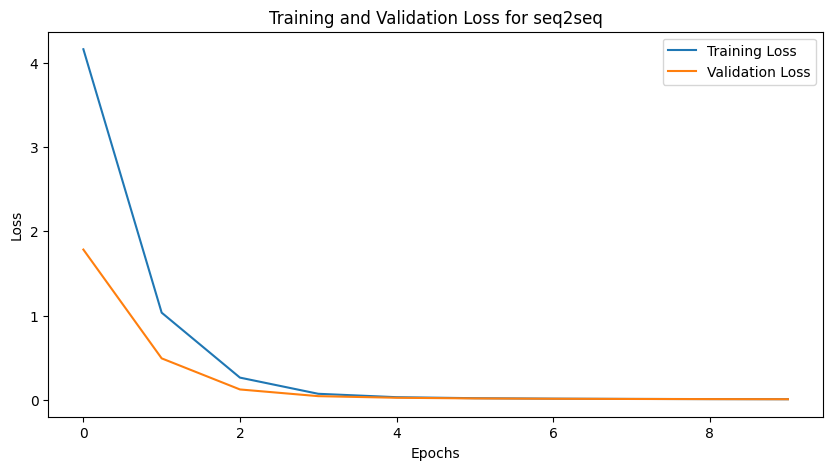

In [10]:


# Plot the training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss for seq2seq')
    plt.show()

plot_losses(train_losses, val_losses)

In [28]:
# Translate a new sentence
def translate_new_sentence(model, en_sentence, en_vocab, ic_vocab, max_len=MAX_LEN):
    model.eval()
    en_tensor = sentence_to_tensor(en_sentence, en_vocab, max_len).unsqueeze(0).to(DEVICE)

    # Start with the <s> token as input to the decoder
    ic_input = torch.tensor([ic_vocab['<s>']]).unsqueeze(0).to(DEVICE)

    translated_sentence = []
    with torch.no_grad():
        for _ in range(max_len):
            output = model(en_tensor, ic_input)
            output_token = output.argmax(dim=-1)[:, -1].item()  # Get the most likely next token

            translated_sentence.append(output_token)
            if output_token == ic_vocab['</s>']:  # End token
                break

            # Update the input for the next time step (use the predicted token)
            ic_input = torch.tensor([output_token]).unsqueeze(0).to(DEVICE)  # Convert output_token to tensor

    # Convert token IDs back to words
    translated_sentence = [k for k, v in ic_vocab.items() if v in translated_sentence]
    return " ".join(translated_sentence)

# Example sentence translation
en_example_sentence = "This is a test sentence."
translated_ic_sentence = translate_new_sentence(model, en_example_sentence, en_vocab, ic_vocab)
print(f"Original: {en_example_sentence}")
print(f"Translated: {translated_ic_sentence}")


Original: This is a test sentence.
Translated: <s> gefðu þrjú ráð halda heilsu borðaðu hollt næringarríkt mataræði gakktu máltíðirnar þínar innihaldi margs konar ávexti grænmeti magurt prótein heilkorn holla fitu þetta veita líkamanum nauðsynleg næringarefni virka best hjálpað koma veg langvinna sjúkdóma taktu þátt reglulegri hreyfing mikilvæg viðhalda sterkum beinum vöðvum hjarta æðaheilbrigði minnsta kosti 150 hóflegri þolþjálfun 75 öflugri viku fáðu fá gæðasvefn skiptir sköpum andlega vellíðan stjórna skapi bæta vitræna virkni heilbrigðan vöxt ónæmisvirkni 79 nóttu hverjir gulur þessir litir kallaðir blanda öðrum litum alla aðra liti sameina ýmsum hlutföllum auklitakerfinu notað ljós grænn rgb byggingu atóm grunnbygging alls efnis samsett þremur tegundum agna rafeindum lýsa má uppbyggingu miðjunni umkringdur rafeindaskýi kjarni gerður róteindir jákvætt nifteindir hlutlausar án hleðslu báðar þessar staðsettar miðju inniheldur mestan hluta umhverfis rafeindaský rafeindir neikvætt stöð